In [1]:
import numpy as np
train = np.loadtxt('Assignment1.2/train2.csv', delimiter=',', skiprows=1)
feature_name = np.loadtxt('Assignment1.2/train2.csv', delimiter=',', max_rows=1, dtype=str)
feature_name = [str(name) for name in feature_name]
for i in range(len(feature_name)):
    print(f"{i+1}  {feature_name[i]}")

1  Hospital Service Area
2  Hospital County
3  Operating Certificate Number
4  Permanent Facility Id
5  Facility Name
6  Age Group
7  Zip Code - 3 digits
8  Total Costs
9  Race
10  Ethnicity
11  Length of Stay
12  Type of Admission
13  Patient Disposition
14  CCSR Diagnosis Code
15  CCSR Procedure Code
16  APR DRG Code
17  APR MDC Code
18  APR Severity of Illness Description
19  APR Risk of Mortality
20  APR Medical Surgical Description
21  Payment Typology 1
22  Payment Typology 2
23  Payment Typology 3
24  Birth Weight
25  Emergency Department Indicator
26  Gender


In [2]:
X = train[:, :-1]
Y = train[:, -1]
X_test = np.loadtxt('Assignment1.2/test2.csv', delimiter=',', skiprows=1)
Y_test = np.loadtxt('Assignment1.2/test_pred2.csv', delimiter=',', skiprows=1)

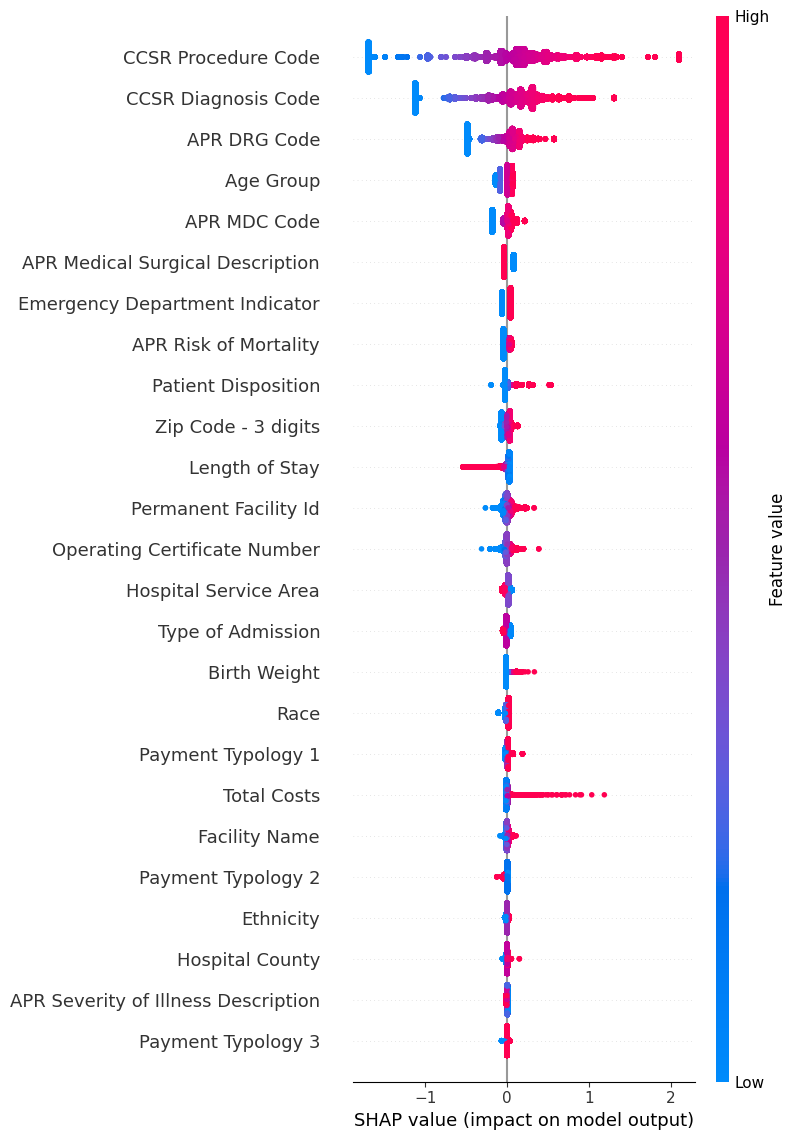

In [5]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

cat_ind=[0,1,2,3,4,5,6,8,9,11,12,13,14,15,16,17,18,19,20,21,22,24]
# def encode(X,y,cat_ind):
#     X_encoded = np.copy(X)
#     for idx in cat_ind:
#         unique_values = np.unique(X[:, idx])
#         mean_target = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
#         encoding_map = dict(zip(unique_values, mean_target))
#         X_encoded[:, idx] = np.array([encoding_map[value] for value in X[:, idx]])
    
#     return X_encoded

# def compute_target_encoding(X, y, cat_ind):
#     encoding_maps = {}
#     for idx in cat_ind:
#         unique_values = np.unique(X[:, idx])
#         mean_target = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
#         encoding_maps[idx] = dict(zip(unique_values, mean_target))
#     return encoding_maps

def compute_target_encoding(X, y, cat_ind, alpha=0):
    encoding_maps = {}
    global_mean = np.mean(y)
    for idx in cat_ind:
        unique_values = np.unique(X[:, idx])
        category_means = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
        category_counts = np.array([np.sum(X[:, idx] == value) for value in unique_values])
        
        # Apply smoothing
        smoothed_means = (category_means * category_counts + global_mean * alpha) / (category_counts + alpha)
        encoding_maps[idx] = dict(zip(unique_values, smoothed_means))
    
    return encoding_maps

def apply_target_encoding(X, encoding_maps):
    X_encoded = np.copy(X)
    for idx, encoding_map in encoding_maps.items():
        X_encoded[:, idx] = np.array([encoding_map.get(value, 0) for value in X[:, idx]])
    return X_encoded

enc= compute_target_encoding(X,Y,cat_ind)
X_shap= apply_target_encoding(X,enc)
scaler = StandardScaler()
X_shap= scaler.fit_transform(X_shap)
model = LogisticRegression().fit(X_shap, Y)

# X_test= apply_target_encoding(X_test,enc)
# X_test= scaler.transform(X_test)

explainer = shap.LinearExplainer(model, X_shap)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, feature_names=feature_name, max_display=35)


In [ ]:
from sklearn.feature_selection import f_classif
F_values, p_values = f_classif(X, Y)
print("F-values:", F_values)
print("P-values:", p_values)

In [ ]:
features_with_pvalues = list(zip(feature_name, p_values))
sorted_features = sorted(features_with_pvalues, key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_p_values = zip(*sorted_features)
for name, p_value in zip(sorted_feature_names, sorted_p_values):
    print(f"{name.ljust(35)} | {p_value:.4f}".rjust(20))

In [ ]:
features_with_fvalues = list(zip(feature_name, F_values))
sorted_features = sorted(features_with_fvalues, key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_f_values = zip(*sorted_features)
for name, f_value in zip(sorted_feature_names, sorted_f_values):
    print(f"{name.ljust(35)} | {f_value:.4f}".rjust(20))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features including interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X)
interaction_feature_names = []

# Add interaction names
n= len(feature_name)
for i in range(n):
    interaction_feature_names.append(feature_name[i])

for i in range(n):
    for j in range(i + 1, n):
        interaction_feature_names.append(f"{feature_name[i]} * {feature_name[j]}")

from sklearn.feature_selection import f_classif

# Apply ANOVA to interaction terms
_, p_values = f_classif(X_interaction, Y)

# Select features based on p-values
significant_features = np.where(p_values < 0.05)[0]  # Example threshold
interaction_feature_names = [str(name) for name in interaction_feature_names]

In [ ]:
# for index in significant_features:
#     print(interaction_feature_names[index])

In [ ]:
print(len(significant_features))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Fit the logistic regression model with L1 penalty
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X, Y)

# Select features based on coefficients
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X)

# Check the selected features
selected_features = selector.get_support(indices=True)
print(selected_features)
print(len(selected_features))
for index in selected_features:
    print(feature_name[index])


In [44]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features including interaction terms
cat_ind=[0,1,2,3,4,5,6,8,9,11,12,13,14,15,16,17,18,19,20,21,22,24]
poly = PolynomialFeatures(interaction_only=True, include_bias=True)
X_interaction = poly.fit_transform(X[:,cat_ind])
feature_names=[]
for ind in cat_ind:
    feature_names.append(feature_name[ind])

# Generate feature names for interaction features
interaction_feature_names = []
n = len(feature_names)
for i in range(n):
    interaction_feature_names.append(feature_names[i])
for i in range(n):
    for j in range(i + 1, n):
        interaction_feature_names.append(f"{feature_names[i]} * {feature_names[j]}")

In [45]:
import numpy as np

def compute_target_encoding(X, y, cat_ind):
    encoding_maps = {}
    global_mean = np.mean(y)
    for idx in cat_ind:
        unique_values = np.unique(X[:, idx])
        category_means = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
        category_counts = np.array([np.sum(X[:, idx] == value) for value in unique_values])
        
        # Apply smoothing
        alpha = 100  # Adjust as needed
        smoothed_means = (category_means * category_counts + global_mean * alpha) / (category_counts + alpha)
        encoding_maps[idx] = dict(zip(unique_values, smoothed_means))
    
    return encoding_maps


def apply_target_encoding(X, encoding_maps):
    X_encoded = np.copy(X)
    for idx, encoding_map in encoding_maps.items():
        X_encoded[:, idx] = np.array([encoding_map.get(value, 0) for value in X[:, idx]])
    return X_encoded

# Compute target encoding for interaction features
interaction_indices = list(range(X_interaction.shape[1]))
encoding_maps = compute_target_encoding(X_interaction, Y, interaction_indices)
X_encoded = apply_target_encoding(X_interaction, encoding_maps)


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_encoded)


/opt/homebrew/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


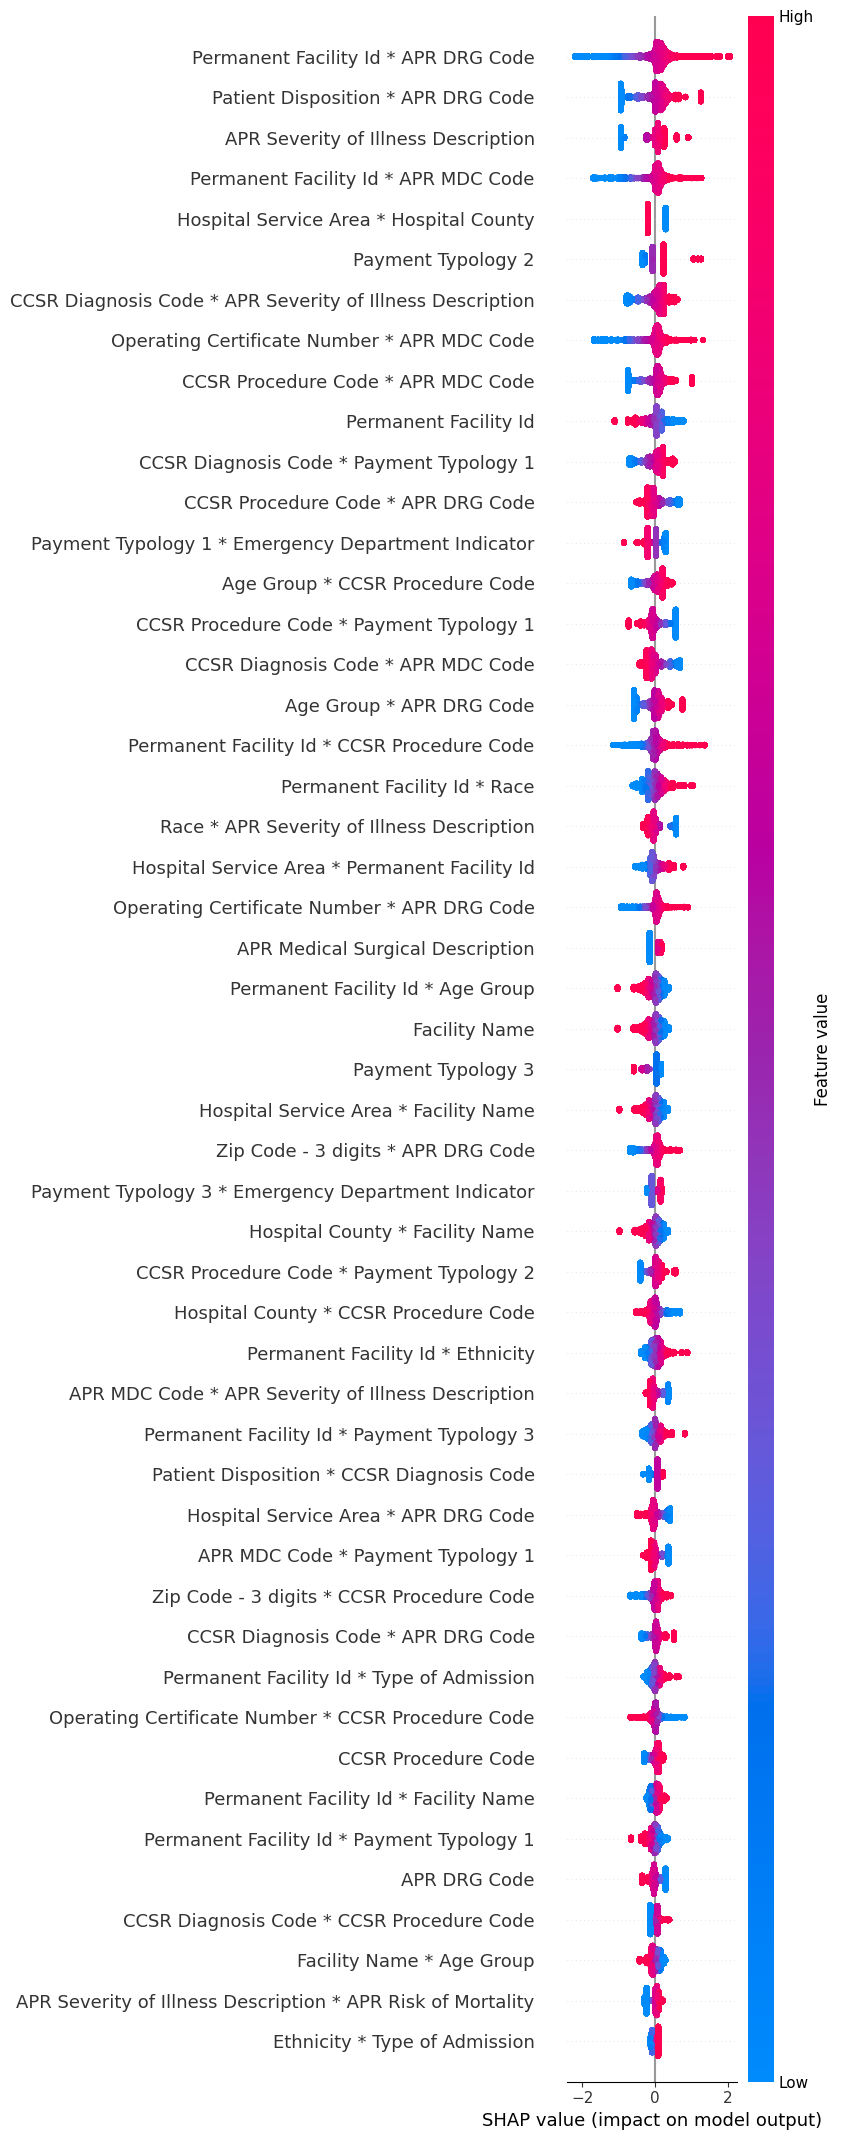

In [47]:
import shap
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_standardized, Y)
explainer = shap.LinearExplainer(model, X_standardized)
shap_values = explainer.shap_values(X_standardized)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_standardized, feature_names=interaction_feature_names, max_display=50)

In [48]:
from sklearn.metrics import accuracy_score
X_test = poly.fit_transform(X_test[:,cat_ind])
X_test = apply_target_encoding(X_test, encoding_maps)
X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6524
